In [1]:
# Librerías: datos, numérico, gráficos y funciones estadísticas (EVT/copulas)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats as stats
from scipy.stats import genpareto, invgamma, lognorm, gaussian_kde
from scipy import optimize
from scipy.special import gammaln

# Leer datos y limpieza básica
df = pd.read_csv(r"C:\Users\harc0\Downloads\datos_limpios.csv").dropna()

# Divide entre mil por un error en los decimales cuando se carga la base
df["total"] = df["total"] / 1000

print(df.columns)

Index(['Unnamed: 0', 'ano', 'evento', 'categoria', 'decreto', 'provincia',
       'canton', 'latitud', 'longitud', 'tipologia', 'total'],
      dtype='object')


In [2]:
import numpy as np, pandas as pd
from scipy import stats

# Agregación: matriz n×K por tipología (año–provincia)
g = (df.groupby(["ano","provincia","tipologia"])["total"]
       .sum()
       .unstack(fill_value=0)
       .reset_index(drop=True))

tipologias = g.columns.tolist()
X = g.values.astype(float)
n, K = X.shape

# Pseudo-observaciones (rank/(n+1))
def pobs_colwise(X):
    U = np.empty_like(X, dtype=float)
    for j in range(X.shape[1]):
        r = stats.rankdata(X[:, j], method="average")
        U[:, j] = r/(len(r)+1.0)
    return U

U = pobs_colwise(X)

# Estadísticos de cola superior (no paramétrico)
def tail_stats(U, q, m_at_least=None):
    if m_at_least is None:
        mask = (U > q).all(axis=1)            # todas K exceden q
    else:
        mask = (U > q).sum(axis=1) >= m_at_least   # al menos m exceden q
    return float(mask.mean())

# Bootstrap nulo bajo independencia (idéntico a gauss/t no paramétrico)
def bootstrap_tail_test(n, K, q, B=2000, seed=123, m_at_least=None):
    rng = np.random.default_rng(seed)
    T_star = np.empty(B)
    for b in range(B):
        U_star = rng.uniform(size=(n, K))     # U* ~ Unif(0,1)^K
        if m_at_least is None:
            mask = (U_star > q).all(axis=1)
        else:
            mask = (U_star > q).sum(axis=1) >= m_at_least
        T_star[b] = mask.mean()
    return T_star

# Grid (q, m)
q_grid = [0.85, 0.90, 0.92]
m_grid = [max(2, int(np.ceil(frac * K))) for frac in [0.15, 0.20, 0.25]]

# Cálculo de T(q,·) y p-valores bootstrap (no paramétrico)
results_np = []
B = 2000

for q in q_grid:
    # all_K
    Tq_all = tail_stats(U, q, m_at_least=None)
    T_star_all = bootstrap_tail_test(n, K, q, B=B, seed=3100+int(q*100), m_at_least=None)
    p_all = float((T_star_all >= Tq_all).mean())
    results_np.append({"q": q, "criterion": "all_K", "m": None, "Tq": Tq_all, "p_value": p_all})
    # at_least_m
    for m in m_grid:
        Tq_m = tail_stats(U, q, m_at_least=m)
        T_star_m = bootstrap_tail_test(n, K, q, B=B, seed=4100+int(10*q)+m, m_at_least=m)
        p_m = float((T_star_m >= Tq_m).mean())
        results_np.append({"q": q, "criterion": "at_least_m", "m": m, "Tq": Tq_m, "p_value": p_m})

df_res_np = pd.DataFrame(results_np).sort_values(["q","criterion","p_value"], ascending=[True,True,True]).reset_index(drop=True)

print("Resultados cola superior (no paramétrico, grid q ∈ {0.85,0.90,0.92}):")
print(df_res_np)


Resultados cola superior (no paramétrico, grid q ∈ {0.85,0.90,0.92}):
       q   criterion    m        Tq  p_value
0   0.85       all_K  NaN  0.000000   1.0000
1   0.85  at_least_m  6.0  0.164384   0.0695
2   0.85  at_least_m  5.0  0.205479   0.6930
3   0.85  at_least_m  4.0  0.301370   0.9935
4   0.90       all_K  NaN  0.000000   1.0000
5   0.90  at_least_m  6.0  0.095890   0.0000
6   0.90  at_least_m  5.0  0.123288   0.0410
7   0.90  at_least_m  4.0  0.205479   0.2475
8   0.92       all_K  NaN  0.000000   1.0000
9   0.92  at_least_m  6.0  0.041096   0.0140
10  0.92  at_least_m  5.0  0.068493   0.0530
11  0.92  at_least_m  4.0  0.123288   0.2330


In [3]:
# Toma una matriz S (de covarianza o correlación) y la "proyecta" 
# para garantizar que sea una matriz de correlación válida (simétrica, positiva definida, con 1s en la diagonal).
def project_to_corr(S):
    D = np.sqrt(np.diag(S))                           
    C = S / np.outer(D, D)                            
    np.fill_diagonal(C, 1.0)                       
    w, V = np.linalg.eigh(C)                          
    w = np.clip(w, 1e-6, None)                       
    Cpos = V @ np.diag(w) @ V.T                       
    Cpos /= np.outer(np.sqrt(np.diag(Cpos)), np.sqrt(np.diag(Cpos)))  # Normaliza nuevamente a correlación
    np.fill_diagonal(Cpos, 1.0)
    return Cpos


# Calcula el logaritmo de la verosimilitud de una t-cópula multivariada.
# U es una matriz de valores uniformes (pseudo-observaciones), Sigma la matriz de correlación,
# y nu los grados de libertad de la distribución t.
def log_cop_t(U, Sigma, nu):
    Z = stats.t.ppf(U, df=nu)                        
    K = Z.shape[1]                                    
    sign, logdet = np.linalg.slogdet(Sigma)           
    invS = np.linalg.inv(Sigma)                      
    quad = np.einsum('ij,jk,ik->i', Z, invS, Z)      
    log_cte = gammaln((nu + K)/2.0) - gammaln(nu/2.0) - 0.5*logdet - (K/2.0)*np.log(nu*np.pi)
    log_joint = log_cte - ((nu + K)/2.0)*np.log(1.0 + quad/nu)  
    log_marg = stats.t.logpdf(Z, df=nu)             
    return float(np.sum(log_joint - np.sum(log_marg, axis=1)))   



# Ajusta una t-cópula a los datos U mediante máxima verosimilitud iterativa.
# Devuelve la matriz de correlación estimada (Sigma), los grados de libertad (nu) y el log-likelihood final.
def fit_t_copula(U, max_iter=6):
    Z0 = stats.norm.ppf(U)                            
    Sigma = np.corrcoef(Z0, rowvar=False)             
    Sigma = project_to_corr(Sigma)                    
    lo, hi = 2.1, 200.0                        
    x0 = np.log(8.0 - lo)                           


    def map_x(x):
        sp = np.log1p(np.exp(x))
        return float(min(lo + sp, hi))

    for _ in range(max_iter): 
        
        def nll_nu(x):
            nu_ = map_x(x[0])
            return -log_cop_t(U, Sigma, nu_)


        res = optimize.minimize(nll_nu, x0=np.array([x0]), method="L-BFGS-B")
        nu = map_x(res.x[0]); x0 = res.x[0]


        Zt = stats.t.ppf(U, df=nu)
        Sigma = np.corrcoef(Zt, rowvar=False)
        Sigma = project_to_corr(Sigma)

    LL = log_cop_t(U, Sigma, nu)                      # Log-verosimilitud final
    return Sigma, nu, LL


#Ajuste del modelo t-cópula
Sigma_hat_t, nu_hat_t, LL_obs_t = fit_t_copula(U)


LR_obs_t = 2.0 * LL_obs_t
print({"model": "t-multivariada", "nu_hat": float(nu_hat_t), "LR_obs": float(LR_obs_t)})


#Evaluación del comportamiento en colas
q_grid = [0.85, 0.9, 0.92, 0.95] 

results_t = []
for q in q_grid:
     # all_K
    Tq_all = tail_stats(U, q, m_at_least=None)
    T_star_all = bootstrap_tail_test(n, K, q, B=B, seed=3000+int(q*100), m_at_least=None)
    p_all = float((T_star_all >= Tq_all).mean())
    results_t.append({"q": q, "criterion": "all_K", "m": None, "Tq": Tq_all, "p_value": p_all})

    # at_least_m
    for m in m_grid:
        Tq_m = tail_stats(U, q, m_at_least=m)
        T_star_m = bootstrap_tail_test(n, K, q, B=B, seed=4000+int(10*q)+m, m_at_least=m)
        p_m = float((T_star_m >= Tq_m).mean())
        results_t.append({"q": q, "criterion": "at_least_m", "m": m, "Tq": Tq_m, "p_value": p_m})

df_res_t = pd.DataFrame(results_t).sort_values(["q","criterion","p_value"], ascending=[True,True,True]).reset_index(drop=True)

print("\nResultados cola superior (t-cópula multivariada, grid q ∈ {0.85,0.90,0.92,0.95}):")
print(df_res_t)




{'model': 't-multivariada', 'nu_hat': 8.122261626038037, 'LR_obs': 1054.9153616888084}

Resultados cola superior (t-cópula multivariada, grid q ∈ {0.85,0.90,0.92,0.95}):
       q   criterion    m        Tq  p_value
0   0.85       all_K  NaN  0.000000   1.0000
1   0.85  at_least_m  6.0  0.164384   0.0525
2   0.85  at_least_m  5.0  0.205479   0.7090
3   0.85  at_least_m  4.0  0.301370   0.9890
4   0.90       all_K  NaN  0.000000   1.0000
5   0.90  at_least_m  6.0  0.095890   0.0000
6   0.90  at_least_m  5.0  0.123288   0.0385
7   0.90  at_least_m  4.0  0.205479   0.2695
8   0.92       all_K  NaN  0.000000   1.0000
9   0.92  at_least_m  6.0  0.041096   0.0140
10  0.92  at_least_m  5.0  0.068493   0.0535
11  0.92  at_least_m  4.0  0.123288   0.2435
12  0.95       all_K  NaN  0.000000   1.0000
13  0.95  at_least_m  4.0  0.068493   0.0185
14  0.95  at_least_m  5.0  0.027397   0.0285
15  0.95  at_least_m  6.0  0.000000   1.0000


In [4]:
#Log-verosimilitud de la cópula gaussiana
# U: pseudo-observaciones; Sigma: matriz de correlación
def log_cop_gauss(U, Sigma):
    Z = stats.norm.ppf(U)                         
    K = Z.shape[1]
    invS = np.linalg.inv(Sigma)
    sign, logdet = np.linalg.slogdet(Sigma)
    quad = np.einsum('ij,jk,ik->i', Z, (invS - np.eye(K)), Z)
    return float(np.sum(-0.5*logdet - 0.5*quad))

# Ajuste de la cópula gaussiana
def fit_gaussian_copula(U):
    Z = stats.norm.ppf(U)
    Sigma = np.corrcoef(Z, rowvar=False)        
    Sigma = project_to_corr(Sigma)                
    LL = log_cop_gauss(U, Sigma)
    return Sigma, LL

# Ajuste del modelo gaussiano
Sigma_hat_g, LL_obs_g = fit_gaussian_copula(U)
LR_obs_g = 2.0 * LL_obs_g
print({"model": "gaussiana", "LR_obs": float(LR_obs_g)})

# Evaluación del comportamiento en colas 
q_grid = [0.85, 0.90, 0.92, 0.95]

results_g = []
for q in q_grid:
    # all_K
    Tq_all = tail_stats(U, q, m_at_least=None)
    T_star_all = bootstrap_tail_test(n, K, q, B=B, seed=5000+int(q*100), m_at_least=None)
    p_all = float((T_star_all >= Tq_all).mean())
    results_g.append({"q": q, "criterion": "all_K", "m": None, "Tq": Tq_all, "p_value": p_all})
    # at_least_m
    for m in m_grid:
        Tq_m = tail_stats(U, q, m_at_least=m)
        T_star_m = bootstrap_tail_test(n, K, q, B=B, seed=6000+int(10*q)+m, m_at_least=m)
        p_m = float((T_star_m >= Tq_m).mean())
        results_g.append({"q": q, "criterion": "at_least_m", "m": m, "Tq": Tq_m, "p_value": p_m})

df_res_g = pd.DataFrame(results_g).sort_values(["q","criterion","p_value"], ascending=[True,True,True]).reset_index(drop=True)
print("\nResultados cola superior (cópula gaussiana, grid q ∈ {0.85,0.90,0.92,0.95}):")
print(df_res_g)



{'model': 'gaussiana', 'LR_obs': 899.2173004135068}

Resultados cola superior (cópula gaussiana, grid q ∈ {0.85,0.90,0.92,0.95}):
       q   criterion    m        Tq  p_value
0   0.85       all_K  NaN  0.000000   1.0000
1   0.85  at_least_m  6.0  0.164384   0.0540
2   0.85  at_least_m  5.0  0.205479   0.7010
3   0.85  at_least_m  4.0  0.301370   0.9880
4   0.90       all_K  NaN  0.000000   1.0000
5   0.90  at_least_m  6.0  0.095890   0.0000
6   0.90  at_least_m  5.0  0.123288   0.0320
7   0.90  at_least_m  4.0  0.205479   0.2740
8   0.92       all_K  NaN  0.000000   1.0000
9   0.92  at_least_m  6.0  0.041096   0.0080
10  0.92  at_least_m  5.0  0.068493   0.0395
11  0.92  at_least_m  4.0  0.123288   0.2610
12  0.95       all_K  NaN  0.000000   1.0000
13  0.95  at_least_m  4.0  0.068493   0.0205
14  0.95  at_least_m  5.0  0.027397   0.0345
15  0.95  at_least_m  6.0  0.000000   1.0000


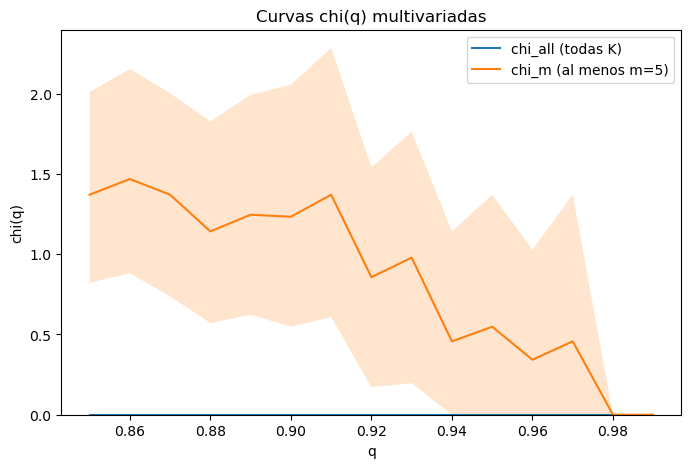

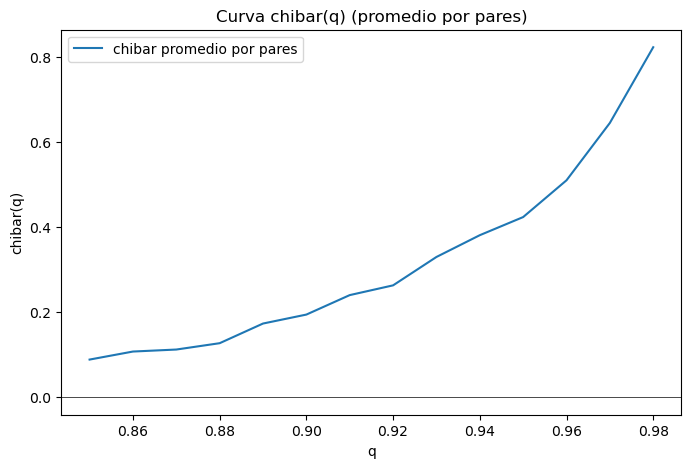

In [5]:
g = (df.groupby(["ano","provincia","tipologia"])["total"]
       .sum()
       .unstack(fill_value=0)
       .reset_index(drop=True))
X = g.values.astype(float)         
n, K = X.shape

def pobs_colwise(X):
    U = np.empty_like(X, dtype=float)
    for j in range(X.shape[1]):
        r = stats.rankdata(X[:, j], method="average")
        U[:, j] = r/(len(r)+1.0)
    return U

U = pobs_colwise(X)


def chi_all(U, q):
    p_joint = np.mean((U > q).all(axis=1))
    return p_joint / max(1e-12, (1.0 - q))

def chi_m(U, q, m):
    p_joint = np.mean((U > q).sum(axis=1) >= m)
    return p_joint / max(1e-12, (1.0 - q))

def chibar_from_pairs(U, q):
    K = U.shape[1]
    vals = []
    for i in range(K):
        for j in range(i+1, K):
            p_min = np.mean((U[:, i] > q) & (U[:, j] > q))
            if p_min > 0:
                vals.append(2*np.log(1-q)/np.log(max(1e-12, p_min)) - 1.0)
    return float(np.mean(vals)) if vals else np.nan

def bootstrap_stat(fn, U, q_grid, B=1000, rng=np.random.default_rng(123), **kwargs):
    stats_star = np.empty((B, len(q_grid)))
    n, K = U.shape
    for b in range(B):
        idx = rng.integers(0, n, size=n)
        Ub = U[idx, :]
        stats_star[b, :] = [fn(Ub, q, **kwargs) for q in q_grid]
    lo = np.nanpercentile(stats_star, 2.5, axis=0)
    hi = np.nanpercentile(stats_star, 97.5, axis=0)
    return lo, hi

q_grid = np.linspace(0.85, 0.99, 15)
m = max(2, int(np.ceil(0.2 * K)))   

chi_all_vals = np.array([chi_all(U, q) for q in q_grid])
chi_m_vals   = np.array([chi_m(U, q, m) for q in q_grid])
chibar_vals  = np.array([chibar_from_pairs(U, q) for q in q_grid])

lo_all, hi_all = bootstrap_stat(chi_all, U, q_grid, B=800)
lo_m,   hi_m   = bootstrap_stat(lambda Ux, q: chi_m(Ux, q, m), U, q_grid, B=800)

plt.figure(figsize=(8,5))
plt.plot(q_grid, chi_all_vals, label=f"chi_all (todas K)")
plt.fill_between(q_grid, lo_all, hi_all, alpha=0.2)
plt.plot(q_grid, chi_m_vals, label=f"chi_m (al menos m={m})")
plt.fill_between(q_grid, lo_m, hi_m, alpha=0.2)
plt.axhline(0, color='k', lw=0.5)
plt.ylim(bottom=0)
plt.xlabel("q")
plt.ylabel("chi(q)")
plt.title("Curvas chi(q) multivariadas")
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(q_grid, chibar_vals, label="chibar promedio por pares")
plt.axhline(0, color='k', lw=0.5)
plt.xlabel("q")
plt.ylabel("chibar(q)")
plt.title("Curva chibar(q) (promedio por pares)")
plt.legend()
plt.show()
